Load the 49 industries Value weighted returns and cap weights, and use the period 2013-2018 both included. For the period, use the starting cap weights of the period. Limit yourself to the following 5 industry sectors: 'Hlth', 'Fin', 'Whlsl', 'Rtail', 'Food'.

In [13]:
from google.colab import drive
drive.mount('/content/gdrive/')
import sys
sys.path.append('/content/gdrive/My Drive/import')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [34]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import edhec_risk_kit_206 as erk
import matplotlib
import pandas as pd
import numpy as np

ind49_rets = erk.get_ind_returns(weighting="vw", n_inds=49)["2013":]
ind49_mcap = erk.get_ind_market_caps(49, weights=True)["2013":]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Industry sector has the highest capweight



In [35]:
fiveind_rets = ind49_rets[['Hlth', 'Fin', 'Whlsl', 'Rtail', 'Food']]
fiveind_mcap = ind49_mcap[['Hlth', 'Fin', 'Whlsl', 'Rtail', 'Food']]
cap_w = fiveind_mcap.sum()
cap_w


Hlth     0.396624
Fin      1.751218
Whlsl    0.937026
Rtail    5.057213
Food     1.241093
dtype: float64

In [36]:
def implied_returns(delta, sigma, w):
    """
Obtain the implied expected returns by reverse engineering the weights
Inputs:
delta: Risk Aversion Coefficient (scalar)
sigma: Variance-Covariance Matrix (N x N) as DataFrame
    w: Portfolio weights (N x 1) as Series
Returns an N x 1 vector of Returns as Series
    """
    ir = delta * sigma.dot(w).squeeze() # to get a series from a 1-column dataframe
    ir.name = 'Implied Returns'
    return ir


which industry sector has the highest implied return?

In [37]:
# The 7 countries ...
countries  = ['Hlth', 'Fin', 'Whlsl', 'Rtail', 'Food']
# Table 1 of the He-Litterman paper
# Correlation Matrix
rho = fiveind_rets.corr()

# Table 2 of the He-Litterman paper: volatilities
vols = erk.annualize_vol(fiveind_rets, 1) 
# Table 2 of the He-Litterman paper: cap-weights
w_eq = cap_w
# Compute the Covariance Matrix
sigma_prior = vols.dot(vols.T) * rho
# Compute Pi and compare:
pi = implied_returns(delta=2.5, sigma=sigma_prior, w=w_eq)
(pi*100).round(1)

Hlth     12.0
Fin      13.9
Whlsl    15.8
Rtail    17.5
Food     12.2
Name: Implied Returns, dtype: float64

In [38]:
inds  = ['Hlth', 'Fin', 'Whlsl', 'Rtail', 'Food']
rho = fiveind_rets.corr()
# Table 2 of the He-Litterman paper: volatilities
vols = pd.DataFrame(erk.annualize_vol(fiveind_rets, 1),index=inds, columns=["vol"]) 
# Table 2 of the He-Litterman paper: cap-weights
w_eq = pd.DataFrame(cap_w, index=inds, columns=["CapWeight"])
# Compute the Covariance Matrix
sigma_prior = vols.dot(vols.T) * rho
# Compute Pi and compare:
pi = implied_returns(delta=2.5, sigma=sigma_prior, w=w_eq)
(pi*100).round(1)

Hlth     2.6
Fin      3.2
Whlsl    2.9
Rtail    3.3
Food     2.0
Name: Implied Returns, dtype: float64

Impose the subjective relative view that Hlth will outperform Rtail and Whlsl by 3% (Hint: Use the same logic as View 1 in the He-Litterman paper)

What is the entry you will use for the Pick Matrix P for Whlsl.


In [39]:

q = pd.Series([.03]) # just one view
# start with a single view, all zeros and overwrite the specific view
p = pd.DataFrame([0.]*len(inds), index=inds).T
# find the relative market caps of retail and wholesale to split the
# relative outperformance of health ...
w_Whlsl =  w_eq.loc["Whlsl"]/(w_eq.loc["Whlsl"]+w_eq.loc["Rtail"])
w_Rtail =  w_eq.loc["Rtail"]/(w_eq.loc["Whlsl"]+w_eq.loc["Rtail"])
p.iloc[0]['Hlth'] = 1.
p.iloc[0]['Whlsl'] = -w_Whlsl
p.iloc[0]['Rtail'] = -w_Rtail
(p*100).round(2)

,Hlth,Fin,Whlsl,Rtail,Food
0,100.0,0.0,-15.63,-84.37,0.0


Once you impose this view (use delta = 2.5 and tau = 0.05 as in the paper), which sector has the lowest implied return?

In [40]:
# Assumes that Omega is proportional to the variance of the prior
def proportional_prior(sigma, tau, p):
    """
    Returns the He-Litterman simplified Omega
    Inputs:
    sigma: N x N Covariance Matrix as DataFrame
    tau: a scalar
    p: a K x N DataFrame linking Q and Assets
    returns a P x P DataFrame, a Matrix representing Prior Uncertainties
    """
    helit_omega = p.dot(tau * sigma).dot(p.T)
    # Make a diag matrix from the diag elements of Omega
    return pd.DataFrame(np.diag(np.diag(helit_omega.values)),index=p.index, columns=p.index)

In [41]:
from numpy.linalg import inv

def bl(w_prior, sigma_prior, p, q,
                omega=None,
                delta=2.5, tau=.02):
    """
# Computes the posterior expected returns based on 
# the original black litterman reference model
#
# W.prior must be an N x 1 vector of weights, a Series
# Sigma.prior is an N x N covariance matrix, a DataFrame
# P must be a K x N matrix linking Q and the Assets, a DataFrame
# Q must be an K x 1 vector of views, a Series
# Omega must be a K x K matrix a DataFrame, or None
# if Omega is None, we assume it is
#    proportional to variance of the prior
# delta and tau are scalars
    """
    if omega is None:
        omega = proportional_prior(sigma_prior, tau, p)
    # Force w.prior and Q to be column vectors
    # How many assets do we have?
    N = w_prior.shape[0]
    # And how many views?
    K = q.shape[0]
    # First, reverse-engineer the weights to get pi
    pi = implied_returns(delta, sigma_prior,  w_prior)
    # Adjust (scale) Sigma by the uncertainty scaling factor
    sigma_prior_scaled = tau * sigma_prior  
    # posterior estimate of the mean, use the "Master Formula"
    # we use the versions that do not require
    # Omega to be inverted (see previous section)
    # this is easier to read if we use '@' for matrixmult instead of .dot()
  #     mu_bl = pi + sigma_prior_scaled @ p.T @ inv(p @ sigma_prior_scaled @ p.T + omega) @ (q - p @ pi)
    mu_bl = pi + sigma_prior_scaled.dot(p.T).dot(inv(p.dot(sigma_prior_scaled).dot(p.T) + omega).dot(q - p.dot(pi).values))
    # posterior estimate of uncertainty of mu.bl
#     sigma_bl = sigma_prior + sigma_prior_scaled - sigma_prior_scaled @ p.T @ inv(p @ sigma_prior_scaled @ p.T + omega) @ p @ sigma_prior_scaled
    sigma_bl = sigma_prior + sigma_prior_scaled - sigma_prior_scaled.dot(p.T).dot(inv(p.dot(sigma_prior_scaled).dot(p.T) + omega)).dot(p).dot(sigma_prior_scaled)
    return (mu_bl, sigma_bl)

In [42]:
delta = 2.5
tau = 0.05 # from Footnote 8
# Find the Black Litterman Expected Returns
bl_mu, bl_sigma = bl(w_eq, sigma_prior, p, q, tau = tau)
(bl_mu*100).round(1)


Hlth     3.9
Fin      3.1
Whlsl    2.8
Rtail    2.7
Food     1.7
dtype: float64

Which sector now has the highest weight in the MSR portfolio using the Black-Litterman model?

In [25]:
# for convenience and readability, define the inverse of a dataframe
def inverse(d):
    """
    Invert the dataframe by inverting the underlying matrix
    """
    return pd.DataFrame(inv(d.values), index=d.columns, columns=d.index)

def w_msr(sigma, mu, scale=True):
    """
    Optimal (Tangent/Max Sharpe Ratio) Portfolio weights
    by using the Markowitz Optimization Procedure
    Mu is the vector of Excess expected Returns
    Sigma must be an N x N matrix as a DataFrame and Mu a column vector as a Series
    This implements page 188 Equation 5.2.28 of
    "The econometrics of financial markets" Campbell, Lo and Mackinlay.
    """
    w = inverse(sigma).dot(mu)
    if scale:
        w = w/sum(w) # fix: this assumes all w is +ve
    return w

In [44]:

# Use the Black Litterman expected returns and covariance matrix
w_msr(bl_sigma, bl_mu)

Hlth     0.846251
Fin      0.186634
Whlsl   -0.025817
Rtail   -0.139336
Food     0.132268
dtype: float64

Now, let’s assume you change the relative view. You still think that it Hlth will outperform Rtail and Whlsl but you think that the outperformance will be 5% not the 3% you originally anticipated.

Under this new view which sector has the highest expected return?


In [43]:
q = pd.Series([.05]) # just one view
# start with a single view, all zeros and overwrite the specific view
p = pd.DataFrame([0.]*len(inds), index=inds).T
# find the relative market caps of Whlsl and Rtail to split the
# relative outperformance of Hlth ...
w_Whlsl =  w_eq.loc["Whlsl"]/(w_eq.loc["Whlsl"]+w_eq.loc["Rtail"])
w_Rtail =  w_eq.loc["Rtail"]/(w_eq.loc["Whlsl"]+w_eq.loc["Rtail"])
p.iloc[0]['Hlth'] = 1.
p.iloc[0]['Whlsl'] = -w_Whlsl
p.iloc[0]['Rtail'] = -w_Rtail
(p*100).round(1)
# Find the Black Litterman Expected Returns
bl_mu, bl_sigma = bl(w_eq, sigma_prior, p, q, tau = tau)
(bl_mu*100).round(3)

pi = implied_returns(delta=2.5, sigma=bl_sigma, w=w_eq)
(pi*100).round(1)

Hlth     2.8
Fin      3.3
Whlsl    3.0
Rtail    3.4
Food     2.1
Name: Implied Returns, dtype: float64

Under this new view which sector does the Black-Litterman model assign the highest weight?

In [29]:
def w_star(delta, sigma, mu):
    return (inverse(sigma).dot(mu))/delta

wstar = w_star(delta=2.5, sigma=bl_sigma, mu=bl_mu)
# display w*
(wstar*100).round(1)

Hlth     756.2
Fin      166.8
Whlsl    -23.1
Rtail   -124.5
Food     118.2
dtype: float64

In [30]:
wstar = w_star(delta=2.5, sigma=bl_sigma, mu=bl_mu)
# display w*
wstar


Hlth     7.562402
Fin      1.667826
Whlsl   -0.230709
Rtail   -1.245157
Food     1.181993
dtype: float64

In [31]:
(wstar*100).round(1)
w_eq  = w_msr(delta*sigma_prior, pi, scale=False)
# Display the difference in Posterior and Prior weights
np.round(wstar - w_eq/(1+tau), 3)*100

Hlth     712.8
Fin       -8.3
Whlsl   -116.2
Rtail   -627.1
Food      -5.9
dtype: float64

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
EW,0.051441,0.12464,-0.964406,4.528749,0.061535,0.085260,0.167273,-0.158588
CW,0.079618,0.12945,-0.616326,3.897139,0.059042,0.086189,0.372910,-0.159448


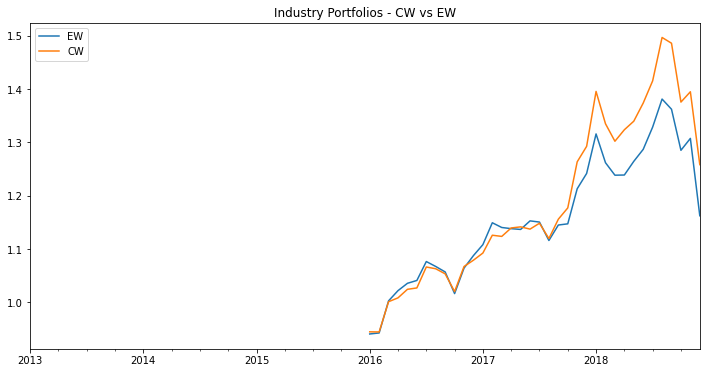

In [45]:

ewr = erk.backtest_ws(fiveind_rets, estimation_window=36, weighting=erk.weight_ew)
cwr = erk.backtest_ws(fiveind_rets, estimation_window=36, weighting=erk.weight_cw, cap_weights=fiveind_mcap)
btr = pd.DataFrame({"EW": ewr, "CW": cwr})
(1+btr).cumprod().plot(figsize=(12,6), title="Industry Portfolios - CW vs EW")
erk.summary_stats(btr.dropna())